In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import progressbar

import os

from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score


In [13]:
articles_metadata = pd.read_csv('D:/Web Traffic/articles_metadata.csv')  
articles_metadata

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


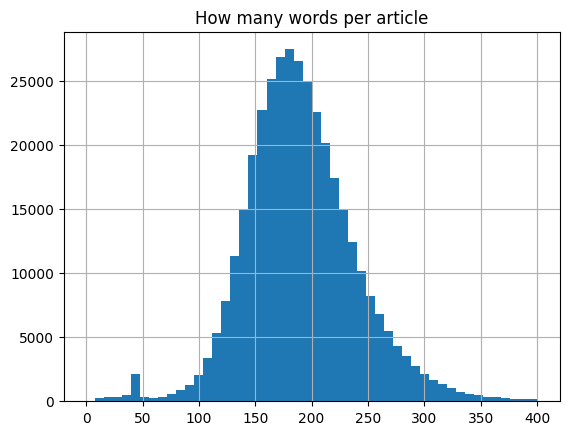

In [14]:
articles_metadata.words_count.hist(bins=50, range=(0,400))
plt.title('How many words per article');

In [15]:
clicks_hour_000 = pd.read_csv('D:/Web Traffic/clicks/clicks_hour_000.csv')  
clicks_hour_000

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,705,1506828968165442,1506828968000,2,119592,1506830912301,4,1,17,1,21,2
1879,705,1506828968165442,1506828968000,2,284847,1506830942301,4,1,17,1,21,2
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1


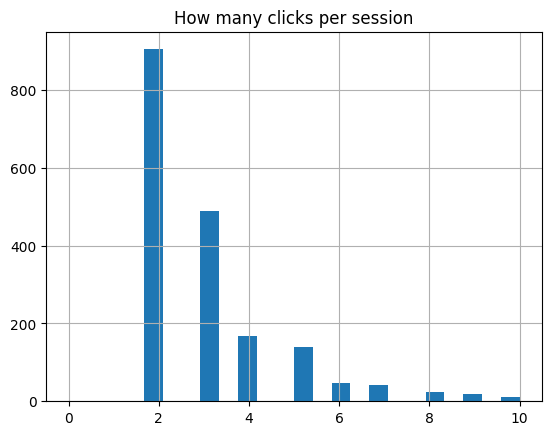

In [16]:
clicks_hour_000.session_size.hist(bins=24, range=(0,10))
plt.title('How many clicks per session');

In [17]:
clicks_hour_000.loc[clicks_hour_000.user_id == 0]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2


In [18]:
clicks_hour_000.loc[clicks_hour_000.session_id == 1506828979881443]

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
1880,706,1506828979881443,1506828979000,3,108854,1506829027334,4,3,2,1,25,1
1881,706,1506828979881443,1506828979000,3,96663,1506829095732,4,3,2,1,25,1
1882,706,1506828979881443,1506828979000,3,68866,1506829125732,4,3,2,1,25,1


In [19]:
%%time

if not os.path.exists('clicks.csv'):
    clicks_path = []
    clicks_dir = "D:/Web Traffic/clicks"

    clicks_path = clicks_path + sorted(
            [
                os.path.join(clicks_dir, fname)
                for fname in os.listdir(clicks_dir)
                if fname.endswith(".csv")
            ]
        )
    print("Number of clicks csv:", len(clicks_path))

    _li = []

    for filename in clicks_path:
        df = pd.read_csv(filename, index_col=None, header=0)
        _li.append(df)

    clicks = pd.concat(_li, axis=0, ignore_index=True)
    clicks.to_csv('clicks.csv')
else:
    clicks= pd.read_csv('clicks.csv')
    
clicks

CPU times: total: 4.14 s
Wall time: 10.7 s


,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2988176,2988176,10051,1508211372158328,1508211372000,2,84911,1508211557302,4,3,2,1,25,1
2988177,2988177,322896,1508211376302329,1508211376000,2,30760,1508211672520,4,1,17,1,25,2
2988178,2988178,322896,1508211376302329,1508211376000,2,157507,1508211702520,4,1,17,1,25,2
2988179,2988179,123718,1508211379189330,1508211379000,2,234481,1508211513583,4,3,2,1,25,2


In [20]:
df = clicks.groupby('user_id').agg(
    LIST_click_article_id = ('click_article_id', lambda x: list(x)),
)
df

,LIST_click_article_id
user_id,
0,"[157541, 68866, 96755, 313996, 160158, 233470,..."
1,"[235840, 96663, 59758, 160474, 285719, 156723,..."
2,"[119592, 30970, 30760, 209122]"
3,"[236065, 236294, 234686, 233769, 235665, 23513..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ..."
...,...
322892,"[42567, 39894]"
322893,"[50644, 36162]"
322894,"[36162, 168401]"


In [21]:
%%time


if not os.path.exists('D:/Web Traffic/df.csv'):
    pbar = progressbar.ProgressBar(widgets=[progressbar.Percentage(), progressbar.Bar()], maxval=len(df)).start()
    
    df['categories'] = ''

    for index, row in df.iterrows():
        pbar.update(index)
        _list_row = []
        
        for article in row['LIST_click_article_id']:
            category_id = articles_metadata[articles_metadata['article_id'] == article]['category_id'].values[0]
            _list_row.append(category_id)
        
        df.at[index, 'categories'] = _list_row

    df.to_csv('D:/Web Traffic/df.csv')
    pbar.finish()
else:
    df = pd.read_csv('D:/Web Traffic/df.csv')

  0%|                                                                         |
  1%|                                                                         |
  2%|#                                                                        |
  3%|##                                                                       |
  5%|###                                                                      |
  6%|####                                                                     |
  7%|#####                                                                    |
  8%|######                                                                   |
 10%|#######                                                                  |
 11%|########                                                                 |
 12%|#########                                                                |
 13%|##########                                                               |
 15%|###########                        

CPU times: total: 18min 5s
Wall time: 47min 44s


In [22]:
df

,LIST_click_article_id,categories
user_id,,
0,"[157541, 68866, 96755, 313996, 160158, 233470,...","[281, 136, 209, 431, 281, 375, 186, 186]"
1,"[235840, 96663, 59758, 160474, 285719, 156723,...","[375, 209, 123, 281, 412, 281, 331, 412, 435, ..."
2,"[119592, 30970, 30760, 209122]","[247, 26, 26, 332]"
3,"[236065, 236294, 234686, 233769, 235665, 23513...","[375, 375, 375, 375, 375, 375, 281, 375, 375, ..."
4,"[48915, 44488, 195887, 195084, 63307, 336499, ...","[92, 81, 317, 317, 132, 437, 399]"
...,...,...
322892,"[42567, 39894]","[67, 66]"
322893,"[50644, 36162]","[99, 43]"
322894,"[36162, 168401]","[43, 297]"


In [25]:
def inputUserRatings(userId):
    _matrix = pd.DataFrame(columns=['click'])
    _row = df.loc[userId]['categories']

    if isinstance(_row, list):
        _row = ' '.join(str(item) for item in _row)


    _row = _row.replace('[', '').replace(']', '').replace(',', '').split()
    
    for index, val in pd.Series(_row).value_counts().items():
        _matrix.loc[index] = int(val)
         
    _matrix['click_norm'] = _matrix.apply(lambda x : x / _matrix['click'].max(), axis=1)
    _matrix = _matrix.reset_index()
    _matrix = _matrix.rename(columns={"index": "category_id"})
    _matrix['category_id'] = _matrix['category_id'].astype(int)
    
    return _matrix


In [26]:
inputUserRatings(0)

,category_id,click,click_norm
0,281,2,1.0
1,186,2,1.0
2,136,1,0.5
3,209,1,0.5
4,431,1,0.5
5,375,1,0.5


In [27]:
articles_matrix = articles_metadata.loc[:, ['article_id', 'category_id']]
display(articles_matrix.dtypes)

article_id     int64
category_id    int64
dtype: object

In [28]:
def recommend5(userId, articles_matrix):
    _input_user_ratings = inputUserRatings(userId)
    _articles_matrix = articles_matrix
    
    _weighed_articles_matrix = pd.DataFrame(columns=['article_id', 'category_id', 'weight'])
    _weighed_articles_matrix['article_id'] = _articles_matrix['article_id']
    _weighed_articles_matrix['category_id'] = _articles_matrix['category_id']
    

    _weighed_articles_matrix['weight'] = _weighed_articles_matrix['category_id'].apply(lambda x :
                                                                                        0                                                                                           
                                                                                       if(_input_user_ratings.loc[_input_user_ratings['category_id'] == x].empty == True)
                                                                                       else
                                                                                        _input_user_ratings.loc[_input_user_ratings['category_id'] == x].click_norm.values[0]
                                                                                      )

    
    return _weighed_articles_matrix[_weighed_articles_matrix.weight > 0].sort_values(by=['weight'], ascending=False)

In [29]:
%%time
res = recommend5(0 , articles_matrix)
res

CPU times: total: 33.9 s
Wall time: 1min 37s


,article_id,category_id,weight
85608,85608,186,1.0
156822,156822,281,1.0
156823,156823,281,1.0
156824,156824,281,1.0
156825,156825,281,1.0
...,...,...,...
316732,316732,431,0.5
316733,316733,431,0.5
316734,316734,431,0.5
316735,316735,431,0.5


In [30]:
clicks.head()

,Unnamed: 0,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [31]:
articles_metadata.head()

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


In [32]:
%%time
dataframe = clicks.merge(articles_metadata, left_on='click_article_id', right_on='article_id')

CPU times: total: 469 ms
Wall time: 2.68 s


In [33]:
dataframe = dataframe[['user_id', 'article_id', 'category_id']]
dataframe

,user_id,article_id,category_id
0,0,157541,281
1,0,68866,136
2,1,235840,375
3,1,96663,209
4,2,119592,247
...,...,...,...
2988176,10051,84911,174
2988177,322896,30760,26
2988178,322896,157507,281
2988179,123718,234481,375


In [34]:
%%time
series = dataframe.groupby(['user_id', 'category_id']).size()
user_rating_matrix = series.to_frame()
user_rating_matrix = user_rating_matrix.reset_index()
user_rating_matrix.rename(columns = {0:'rate'}, inplace = True)

CPU times: total: 625 ms
Wall time: 1.73 s


In [35]:
user_rating_matrix

,user_id,category_id,rate
0,0,136,1
1,0,186,2
2,0,209,1
3,0,281,2
4,0,375,1
...,...,...,...
1882297,322894,297,1
1882298,322895,133,1
1882299,322895,418,1
1882300,322896,26,1


In [37]:
min_rating, max_rating = 1, 10
_x = user_rating_matrix[user_rating_matrix['rate'] > min_rating]
data = _x[['user_id', 'category_id', 'rate']]
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
user_item_matrix = data.pivot(index='user_id', columns='category_id', values='rate').fillna(0)

print(user_item_matrix)

category_id  1    2    4    6    7    9    11   15   16   17   ...  442  443  \
user_id                                                        ...             
0            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
2            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
3            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
4            0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
...          ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
322874       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
322876       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
322879       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
322884       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
322887       0.0  0.0  0.0  0.0  0.0  0.

In [38]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

X = user_item_matrix.values
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

svd = TruncatedSVD(n_components=20, random_state=42)
svd.fit(train_data)

train_pred = svd.transform(train_data)
train_pred = np.dot(train_pred, svd.components_)

test_pred = svd.transform(test_data)
test_pred = np.dot(test_pred, svd.components_)

train_rmse = np.sqrt(mean_squared_error(train_data, train_pred))
test_rmse = np.sqrt(mean_squared_error(test_data, test_pred))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


Train RMSE: 0.20978870175054862
Test RMSE: 0.2029456095642802


In [39]:
from collections import defaultdict


def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
        
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [41]:
def findRecom(dic, userId):
    res = []
    query = dic[userId]
    for uid, user_ratings in query:
        res.append(uid)
    return res

In [43]:
res[['category_id', 'weight']].groupby('category_id').mean().sort_values('weight', ascending=False)

,weight
category_id,
186,1.0
281,1.0
136,0.5
209,0.5
375,0.5
431,0.5


In [44]:
from operator import itemgetter

def find_top_n_indices(data, top=5):
    indexed = enumerate(data)
    sorted_data = sorted(indexed, 
                         key=itemgetter(1), 
                         reverse=True) 
    return [d[0] for d in sorted_data[:top]] 

In [45]:
def recommendFromArticle(article_id, top):
    score = []
    for i in range(0, len(pickle)):
        if(article_id != i):
            cos_sim = np.dot(pickle[article_id], pickle[i])/(np.linalg.norm(pickle[article_id])*np.linalg.norm(pickle[i]))
            score.append(cos_sim)
    
    _best_scores = find_top_n_indices(score, top)
            
    return _best_scores

In [48]:
titles = articles_metadata['article_id']
indices = pd.Series(articles_metadata.index, index=articles_metadata['article_id'])

In [49]:
def simScores(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    
    return sim_scores
    print(sim_scores)

In [50]:
def predictWSimScores(userId):
    _input_user_ratings = inputUserRatings(userId)
    _result = []
    for index, row in _input_user_ratings.iterrows():
        _x = simScores(row.category_id)
        for i in range(1, row.click + 1):
            _result = _result + _x
    return _result